In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal,text_reading

# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import ml_metrics as metrics
import pytesseract
import re
import textdistance

In [2]:
def denoise_images (images, method='nlmeans', ksize=(3,3)):
    
    (lpfw,lpfh) = ksize
    (gfw,gfh) = ksize
    
    new_images = []
    for img in tqdm(images):
        
        if method == 'low_pass':
            lowPassFilter = np.ones((lpfw,lpfh))*1/(lpfw*lpfh)
            denoised_img = cv2.filter2D(img,-1,lowPassFilter)
        elif method == 'gauss':
            #gaussianFilter = gaussFilter((gfw,gfh),1)
            #gaussian_image = cv2.filter2D(img,-1,gaussianFilter)
            denoised_img = cv2.GaussianBlur(img,ksize,0)

        elif method == 'average':
            denoised_img = cv2.blur(img,ksize)
        
        elif method == 'nlmeans':
            denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 15, 15, 13, 21)
            
        elif method == 'median':
            denoised_img = cv2.medianBlur(img,ksize[0])
        else:
            return None 
        
        new_images.append(denoised_img)
        
    return new_images

In [3]:
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")
qsd1_w2, qsd1_w2_files = data_manager.load_data(folder = "./data/qsd1_w2/", extension = ".jpg", desc = "Loading qsd1_w2 Data...")

qsd1_w3, qsd1_w3_files = data_manager.load_data(folder = "./data/qsd1_w3/", extension = ".jpg", desc = "Loading qsd1_w3 Data...")
qsd2_w3, qsd2_w3_files = data_manager.load_data(folder = "./data/qsd2_w3/", extension = ".jpg", desc = "Loading qsd2_w3 Data...")

Loading qsd1_w2 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/BBDD/ read: 287 images


Loading qsd1_w3 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qsd1_w2/ read: 30 images


Loading qsd2_w3 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qsd1_w3/ read: 30 images


Loading qsd2_w3 Data...: 100%|█████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.51it/s]


./data/qsd2_w3/ read: 30 images


Bc
. )
d
les
ne
7 )
J I\

 

  
 

 



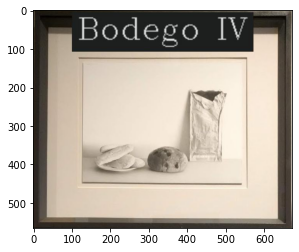

In [4]:

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
text = pytesseract.image_to_string(qsd1_w2[0])
print(text)
plt.imshow(qsd1_w2[0])

In [5]:
BBDD_texts = data_manager.load_text(folder = "./data/BBDD/", extension = ".txt", desc = "Loading BBDD Text...")
print(BBDD_texts)

Loading BBDD Text...: 100%|████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 3270.10it/s]

[('./data/BBDD/bbdd_00000.txt', "('Victor Perez-Porros', 'Des-li-zan-tes')\n"), ('./data/BBDD/bbdd_00001.txt', "('Hugo Demarco', 'Reflecting Room')\n"), ('./data/BBDD/bbdd_00002.txt', '\n'), ('./data/BBDD/bbdd_00003.txt', "('Edvard Munch', 'Youth')\n"), ('./data/BBDD/bbdd_00004.txt', "('Martin Carral', 'Ciclo espacial XXIV')\n"), ('./data/BBDD/bbdd_00005.txt', "('Mario Pasqualotto', 'Els 72 noms de Deu')\n"), ('./data/BBDD/bbdd_00006.txt', "('Gerard Sala', 'S/t')\n"), ('./data/BBDD/bbdd_00007.txt', "('Yago Hortal', 'Kl 45')\n"), ('./data/BBDD/bbdd_00008.txt', "('Josep Guinovart', 'S/t')\n"), ('./data/BBDD/bbdd_00009.txt', '\n'), ('./data/BBDD/bbdd_00010.txt', "('Agusti Puig', 'Sota la lleona')\n"), ('./data/BBDD/bbdd_00011.txt', "('Joan Hernandez Pijuan', 'Serie violetes i verds')\n"), ('./data/BBDD/bbdd_00012.txt', "('Regina Gimenez', 'Navegants')\n"), ('./data/BBDD/bbdd_00013.txt', "('Pere Santilari', 'Berenar de pastisseria')\n"), ('./data/BBDD/bbdd_00014.txt', '\n'), ('./data/BBDD/

In [6]:
BBDD_titles = data_manager.extract_title(data=BBDD_texts,index=1,desc='Extracting titles from DDBB...')
BBDD_authors = data_manager.extract_title(data=BBDD_texts,index=0,desc='Extracting authors from DDBB...')


Extracting authors from DDBB...: 100%|████████████████████████████████████████████| 287/287 [00:00<00:00, 71922.40it/s]


In [7]:
print(BBDD_authors)

['Victor Perez-Porros', 'Hugo Demarco', '', 'Edvard Munch', 'Martin Carral', 'Mario Pasqualotto', 'Gerard Sala', 'Yago Hortal', 'Josep Guinovart', '', 'Agusti Puig', 'Joan Hernandez Pijuan', 'Regina Gimenez', 'Pere Santilari', '', 'Josep Ginovart', 'Corneille', '', '', '', 'Antoni Llena', 'Josep Cisquella', 'Modest Cuixart', 'Per Krohg', 'Joan Pere Viladecans', 'Josep Guinovart', 'Victor Perez-Porro', 'Marco Palazzi', 'Robert Llimos', '', 'Francesca Llopis', 'Pablo Picasso', 'Perejaume', '', 'Jose Luis Pascual', 'Sergi Barnils', '', 'Agusti Puig', '', 'Alfred Figueras', 'Paul Klee', 'Robert Llimos', 'Enrique Barro', 'Narcis Comadira', 'Josep Segu', 'Joan Pere Viladecans', 'Lluis Lleo', 'Xavier Valls', 'Ramiro Fernandez Saus', '', 'Jordi Fulla', 'Alfred Figueras', 'Pere Santilari', 'Alfons Borrell', 'Anna-Eva Bergman', 'Alfons Borrell', '', 'Paul Klee', 'Alfred Figueras', '', 'Jens Ferdinand Willumsen', '', '', 'Edvard Munch', 'Julio Vaquero', '', '', 'Ramon Enrich', 'Jordi Isern', 'Edv

Reading authors from images:   0%|                                                              | 0/30 [00:00<?, ?it/s]

(613, 670, 3)
[[64, 317, 492, 177], [45, 149, 509, 77]]


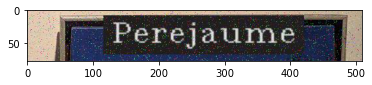

Reading authors from images:   3%|█▊                                                    | 1/30 [00:00<00:19,  1.51it/s]

(1923, 3636, 3)
[[2791, 879, 588, 373], [2795, 691, 599, 70]]


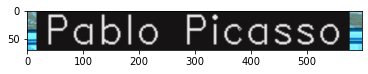

Reading authors from images:   7%|███▌                                                  | 2/30 [00:01<00:19,  1.43it/s]

(704, 1136, 3)
[[636, 292, 391, 124], [105, 158, 308, 37]]


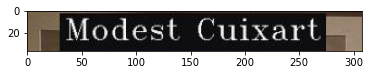

Reading authors from images:  10%|█████▍                                                | 3/30 [00:02<00:18,  1.47it/s]

(1642, 2082, 3)
[[98, 31, 1871, 1516], [1180, 798, 729, 183]]


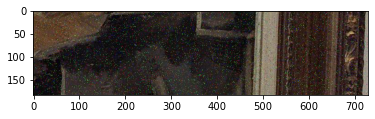

Reading authors from images:  13%|███████▏                                              | 4/30 [00:04<00:32,  1.24s/it]

(2466, 3537, 3)
[[119, 137, 1436, 106], [2869, 1824, 360, 303]]


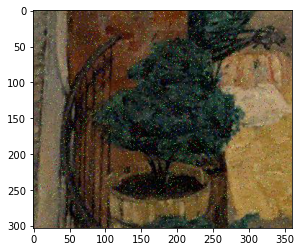

Reading authors from images:  17%|█████████                                             | 5/30 [00:06<00:32,  1.31s/it]

(779, 791, 3)
[[115, 160, 556, 93], [665, 469, 112, 52]]


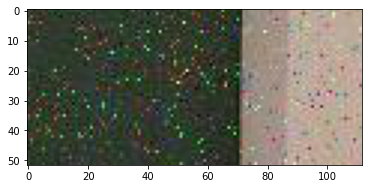

Reading authors from images:  20%|██████████▊                                           | 6/30 [00:06<00:26,  1.10s/it]

(2153, 2124, 3)
[[709, 1978, 645, 90], [0, 0, 0, 0]]


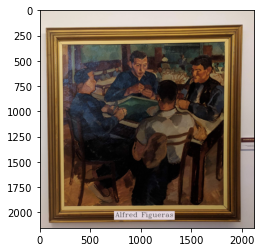

Reading authors from images:  23%|████████████▌                                         | 7/30 [00:09<00:39,  1.71s/it]

(2223, 3776, 3)
[[552, 1828, 644, 85], [2542, 282, 644, 85]]


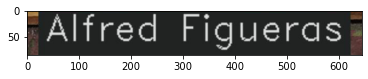

Reading authors from images:  27%|██████████████▍                                       | 8/30 [00:10<00:31,  1.42s/it]

(930, 752, 3)
[[267, 376, 300, 185], [572, 239, 149, 113]]


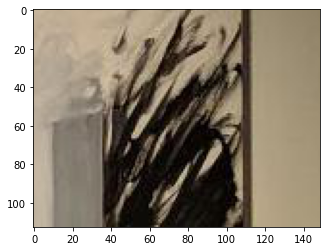

Reading authors from images:  30%|████████████████▏                                     | 9/30 [00:11<00:24,  1.16s/it]

(2066, 4028, 3)
[[617, 389, 645, 90], [2805, 281, 647, 82]]


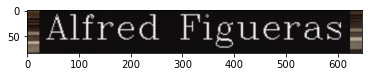

Reading authors from images:  33%|█████████████████▋                                   | 10/30 [00:11<00:20,  1.04s/it]

(745, 583, 3)
[[83, 207, 458, 387], [86, 83, 450, 138]]


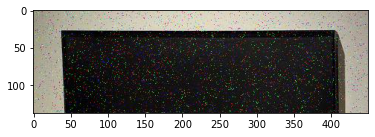

Reading authors from images:  37%|███████████████████▍                                 | 11/30 [00:12<00:17,  1.09it/s]

(1619, 1862, 3)
[[152, 1401, 802, 119], [678, 1388, 615, 60]]


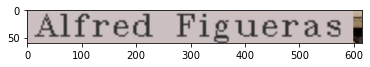

Reading authors from images:  40%|█████████████████████▏                               | 12/30 [00:13<00:14,  1.21it/s]

(398, 731, 3)
[[114, 66, 516, 229], [0, 0, 0, 0]]


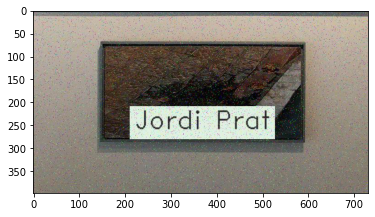

Reading authors from images:  43%|██████████████████████▉                              | 13/30 [00:13<00:14,  1.21it/s]

(2136, 1982, 3)
[[678, 278, 644, 84], [170, 209, 537, 141]]


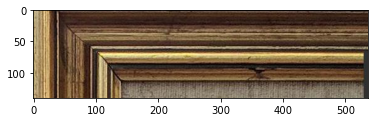

Reading authors from images:  47%|████████████████████████▋                            | 14/30 [00:14<00:13,  1.22it/s]

(650, 676, 3)
[[95, 150, 397, 61], [0, 0, 0, 0]]


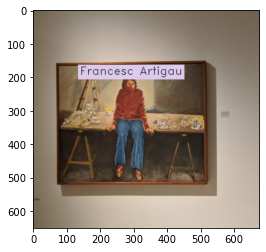

Reading authors from images:  50%|██████████████████████████▌                          | 15/30 [00:15<00:12,  1.18it/s]

(749, 565, 3)
[[108, 594, 357, 31], [144, 314, 249, 38]]


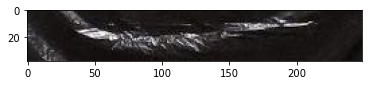

Reading authors from images:  53%|████████████████████████████▎                        | 16/30 [00:16<00:10,  1.29it/s]

(2284, 1616, 3)
[[832, 1501, 729, 722], [37, 151, 1505, 227]]


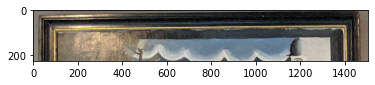

Reading authors from images:  57%|██████████████████████████████                       | 17/30 [00:17<00:11,  1.13it/s]

(1025, 1596, 3)
[[166, 705, 577, 92], [0, 0, 0, 0]]


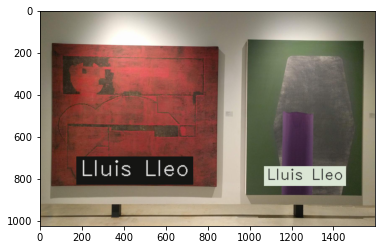

Reading authors from images:  60%|███████████████████████████████▊                     | 18/30 [00:18<00:12,  1.07s/it]

(455, 424, 3)
[[64, 86, 278, 82], [251, 216, 89, 25]]


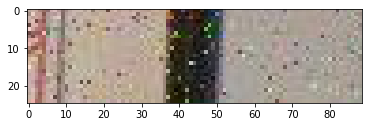

Reading authors from images:  63%|█████████████████████████████████▌                   | 19/30 [00:19<00:09,  1.12it/s]

(2157, 3626, 3)
[[45, 1853, 1641, 237], [2027, 87, 1118, 248]]


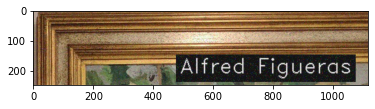

Reading authors from images:  67%|███████████████████████████████████▎                 | 20/30 [00:20<00:09,  1.04it/s]

(876, 728, 3)
[[105, 56, 515, 512], [123, 465, 143, 62]]


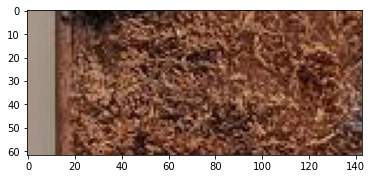

Reading authors from images:  70%|█████████████████████████████████████                | 21/30 [00:21<00:08,  1.12it/s]

(878, 2164, 3)
[[277, 703, 633, 62], [1414, 655, 546, 55]]


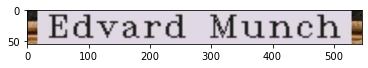

Reading authors from images:  73%|██████████████████████████████████████▊              | 22/30 [00:21<00:06,  1.24it/s]

(1460, 1213, 3)
[[589, 249, 370, 83], [375, 230, 210, 76]]


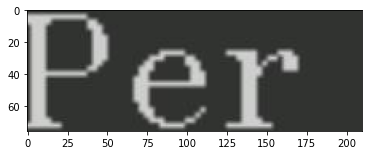

Reading authors from images:  77%|████████████████████████████████████████▋            | 23/30 [00:22<00:05,  1.30it/s]

(846, 908, 3)
[[157, 137, 545, 104], [252, 254, 89, 22]]


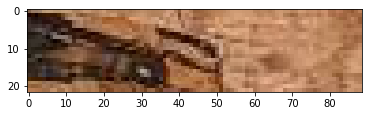

Reading authors from images:  80%|██████████████████████████████████████████▍          | 24/30 [00:23<00:04,  1.42it/s]

(662, 492, 3)
[[75, 156, 349, 55], [0, 0, 0, 0]]


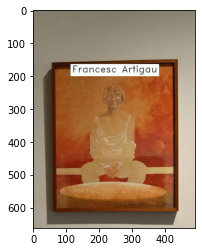

Reading authors from images:  83%|████████████████████████████████████████████▏        | 25/30 [00:23<00:03,  1.42it/s]

(788, 651, 3)
[[123, 161, 385, 58], [0, 0, 0, 0]]


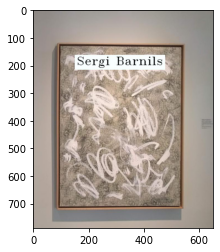

Reading authors from images:  87%|█████████████████████████████████████████████▉       | 26/30 [00:24<00:03,  1.23it/s]

(785, 1523, 3)
[[864, 608, 464, 74], [218, 245, 243, 76]]


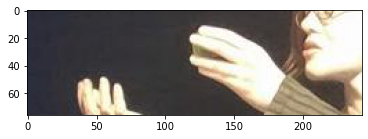

Reading authors from images:  90%|███████████████████████████████████████████████▋     | 27/30 [00:25<00:02,  1.24it/s]

(784, 823, 3)
[[87, 106, 651, 555], [337, 80, 192, 24]]


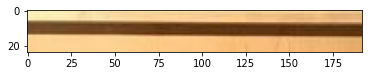

Reading authors from images:  93%|█████████████████████████████████████████████████▍   | 28/30 [00:26<00:01,  1.11it/s]

(730, 584, 3)
[[82, 161, 416, 82], [0, 0, 0, 0]]


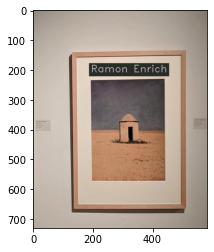

Reading authors from images:  97%|███████████████████████████████████████████████████▏ | 29/30 [00:28<00:01,  1.02s/it]

(1953, 1935, 3)
[[612, 174, 644, 85], [0, 0, 0, 0]]


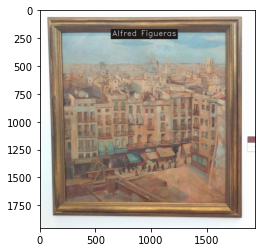

Reading authors from images: 100%|█████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.05s/it]


In [8]:
# Mention the installed location of Tesseract-OCR in your system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
#qsd2_w3_denoised = denoise_images (qsd2_w3,method='nlmeans', ksize=(3,3))
detected_titles = text_reading(data=qsd1_w2,num_images=1,desc='Reading titles from images')
detected_authors = text_reading(data=qsd2_w3,num_images=2,desc='Reading authors from images')
     

In [14]:
print(detected_titles)
print(detected_authors)

['sBodego IV', 'Paisatge', 'Noia al mirallj', 'Les roses', '2 segons abans del traspas', 'Lialmirall Byron', 'iSt', 'Port de mar Eivissa', ' Pintura sobre Ll ', '7 Unknown a', ' ', 'i Unknown ', 'Suite diabolica n 5 ', ' ', ' Mercat a la plaa de Manresa a', 'Rastres i transparencies ', 'Bodego  pastisseria M', ' ', '', ' Bodego ', ' ', 'The Stroll', 'Cadira florida', 'Tol al re mmoxe aimoxe Kel amt ge e', 'Te de nit', 'eLa meva mare', 's Carrer de la Plateriall', 'rie violetes i verds', 'Suite Mediterrania ', '']
[(' ', '    Perejaume'), (' ', 'Pablo Picasso'), ('Joan Ponc  ', ' Modest Cuixart'), ('    ', ' '), ('     i pconmenmenimemennnenans 5 Sb or nr a wena nana bretao wee        ', ' '), (' Alfons Borrell', ''), ('s Alfred Figueras ', '  5 el atedSS       Alfred Figueras'), ('sAlfred Figuerass', 'Alfred Figueras'), (' ', ''), ('Alfred Figueras F', '-Alfred Figueras'), ('Jodn Hernandez Pijuan ', ' '), (' ', 'Alfred Figueras j'), ('    FJordi Prat jim', '         Jordi Prat'), ('-Al

In [15]:
sim = Similarity()

qsd1_w2_similarities = sim.compute_string_similarities(detected_titles,BBDD_titles,desc='Computing string similarity', similarity='levenshtein')
qsd1_w3_similarities = sim.compute_string_similarities(detected_authors,BBDD_authors,desc='Computing string similarity', similarity='levenshtein')

Computing string similarity: 100%|█████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.00it/s]


In [16]:
top_k_qsd1_w2 = sim.get_top_k(qsd1_w2_similarities, db_files, 10, desc='Extracting top 10')
top_k_qsd1_w3 = sim.get_top_k(qsd1_w3_similarities, db_files, 10, desc='Extracting top 10')

Extracting top 10: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 10023.03it/s]


In [17]:
SAVE_RESULTS =False
K=10
predicted_results_qsd1_w2 = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week3/QSD1W2/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w2 = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
predicted_results_qsd1_w3 = data_manager.save_results_1(results = top_k_qsd1_w3, path = "./week3/QSD1W3/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w3 = pickle.load(file = open('./data/qsd2_w3/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results_qsd1_w2, predicted = predicted_results_qsd1_w2, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w2)*metric),len(predicted_results_qsd1_w2)))
metric = metrics.mapk(actual = expected_results_qsd1_w3, predicted = predicted_results_qsd1_w3, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w3)*metric),len(predicted_results_qsd1_w3)))

MAP@10 Score: 67.0000% (20/30)
MAP@10 Score: 0.3333% (0/30)


In [13]:
print(predicted_results_qsd1_w3)
print(expected_results_qsd1_w3)

[[ 77 272  52  79  44  27  46   4 282  92]
 [225 136 187 161 217  45  21 261 169  67]
 [130 187 182 117 121 250  15  64 192 110]
 [ 58 190 151 214 179  34 164 222 200 235]
 [219 200 179 113  21 267 252  87 241  30]
 [ 48 131 160 217 110 250 193  81  31 242]
 [226 107 118 194  86 101 100 177 165  90]
 [192 248  92 283 201 149  88 245 110 104]
 [ 45  83 142 254 235  15  84 245 217 248]
 [270 189 266 240  96 254 180  57 251 168]
 [ 90 194  86 111 262 107 101  50 226 165]
 [270 189 240 266  57  96  91 250  46  69]
 [ 91 223 146 184 162 245  11 234 274 121]
 [ 90 194  86 111 262 107 101  50 226 165]
 [259 149  81 104  99  10 246 162 202 110]
 [221 179  32 169  58 206 104 203 188 212]
 [ 52  13 121 211 247 210 133  77  99 135]
 [ 90 194  86 111 262 107 101  50 226 165]
 [108 152  56 230 229  49  98  97 171 127]
 [272  77  71  52  75  46 248 263 170  28]
 [ 90 194  86 111 262 107 101  50 226 165]
 [260 273 151  60 262 111  90  78   6 118]
 [ 41 217 110 104 182 170 285  81 207 133]
 [242  42  